In [17]:
import numpy as np
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.spatial import cKDTree
import scipy.sparse.linalg as spsl
from scipy import sparse
from sklearn.metrics.pairwise import euclidean_distances
import time

import matplotlib.pyplot as plt

# Diffusion Map

In [18]:
class DiffusionMap(object):
    """
    Diffusion Map object to be used in data analysis for fun and profit.

    Parameters
    ----------
    alpha : scalar, optional
        Exponent to be used for the left normalization in constructing the diffusion map.

    epsilon: string or scalar, optional
        Method for choosing the epsilon.  Currently, the only options are to provide a scalar (epsilon is set to the provided scalar) or 'bgh' (Berry, Giannakis and Harlim).
    n_evecs : int, optional
        Number of diffusion map eigenvectors to return
   
    Examples
    --------
    # initialize diffusion map object with the top two eigenvalues being computed, epsilon set to 0.1
    # and alpha set to 1.0.
    >>> mydmap = DiffusionMap(n_evecs = 10, epsilon = .1, alpha = 1.0)

    """

    def __init__(self, data, alpha=0.05, n_evecs=1):

        self.data = data
        self.alpha = alpha
        self.n_evecs = n_evecs
        
        
    def _compute_kernel_matrix_sparse(self):
        print('--- Computation of sparse distance matrix ---')
        self.kdtree = cKDTree(self.data)
        print('a')
        distance_matrix = self.kdtree.sparse_distance_matrix(self.kdtree, 1, output_type='coo_matrix')
        distance_matrix = coo_tocsr(distance_matrix)  # A rajouter utils
        kernel_matrix = self.compute_intermediate_kernel_matrix(distance_matrix)
        kernel_matrix = self.normalize_kernel_matrix(kernel_matrix)
        
        print(kernel_matrix)
        print('b')
        return kernel_matrix
    
    
    def normalize_kernel_matrix(self, matrix):
            shape = matrix.shape

            row_sums = np.asarray(matrix.sum(axis=1)).squeeze()

            inv_diag = 1.0 / row_sums**self.alpha
            inv_diag[np.isnan(inv_diag)] = 0.0
            Dinv = sparse.spdiags(inv_diag, 0, shape[0], shape[1])

            Wtilde = Dinv @ matrix @ Dinv

            return make_stochastic_matrix(Wtilde) # A rajouter utils
        
        
        
    def compute_intermediate_kernel_matrix(self, distance_matrix):
        """Compute kernel matrix.
        Returns the (unnormalized) Gaussian kernel matrix corresponding to
        the data set and choice of bandwidth `epsilon`.
        Parameters
        ----------
        distance_matrix : scipy.sparse.spmatrix
            A sparse matrix whose entries are the distances between data
            points.
        Returns
        -------
        kernel_matrix : scipy.sparse.spmatrix
            A similarity matrix (unnormalized kernel matrix) obtained by
            applying `kernel_function` to the entries in `distance_matrix`.
        """
        data = distance_matrix.data
        self.eta = np.amax(data)
        transformed_data = np.exp(-np.square(data) / (2.0 * self.eta))
        kernel_matrix = distance_matrix._with_data(transformed_data, copy=True)
        return kernel_matrix    
        
        
        
    def _compute_kernel_matrix(self):
        
        print('--- Computation of euclidean distance ---')
        t0 = time.time()
        distance_matrix = euclidean_distances(self.data, self.data)
        t1 = time.time()-t0
        print('Computation time of Euclidean distance: {}s \n'.format(t1))
        
        
        self.eta = self.alpha*np.amax(distance_matrix)
        print('--- Computation of kernel matrix ---')
        t0 = time.time()
        kernel_matrix = np.exp(-distance_matrix**2/self.eta)
        t1 = time.time()-t0
        print('Computation time of kernel matrix: {}s \n'.format(t1))
        
        return kernel_matrix
    
    
    def _diagonal_normalization(self, matrix, exhibitor):
        diag = matrix.sum(axis=1).transpose()
        normalized_matrix = sps.diags(np.power(diag, exhibitor), 0, shape=(diag.shape[0], diag.shape[0]))
        return normalized_matrix
        
    
    def _find_eigen_values_and_vectors(self, T):

        evals, evecs = spsl.eigs(T, k=(self.n_evecs+1), which='LM')
        ix = evals.argsort()[::-1][1:]
        evals = np.real(evals[ix])
        evecs = np.real(evecs[:, ix])
        dmap = np.dot(evecs, np.diag(evals))
        return dmap, evecs, evals
        
                                                
                                         
    def diffusion_map(self):
                                                
        kernel_matrix = self._compute_kernel_matrix()
        
        print('--- Normalizing kernel matrices ---')
        t0 = time.time()
        
        P_inv = self._diagonal_normalization(kernel_matrix, -1)
        
        # Option 2
        K = sps.csr_matrix.dot(P_inv,sps.csr_matrix.dot(kernel_matrix, P_inv))
        Q_inv2 = (self._diagonal_normalization(K, -1)).power(1/2)  # A modifier to.array()
        T = sps.csr_matrix.dot(Q_inv2,sps.csr_matrix.dot(K, Q_inv2))

        t1 = time.time()-t0
        print('Computation time of normalization: {}s \n'.format(t1))
        
        
        print('--- Finding eigen values ---')
        t0 = time.time()
        dmap, eigen_vectors, eigen_values = self._find_eigen_values_and_vectors(T)
        t1 = time.time()-t0
        print('Computation time of calculating eigen values & vectors: {}s \n'.format(t1))
        
        return dmap, eigen_vectors, eigen_values
        
    
        
        

In [19]:
x_train.shape


(49000, 32, 32, 3)

In [21]:
nb_samples = 30000

DM = DiffusionMap(x_train[:nb_samples].reshape(nb_samples,-1), n_evecs = 100, alpha = 1.0)

t0 = time.time()


dmap, eigen_functions, eigen_values = DM.diffusion_map()
print('Computation time of diffusion map: {}s \n'.format(time.time()-t0))

--- Computation of euclidean distance ---
Computation time of Euclidean distance: 74.45766162872314s 

--- Computation of kernel matrix ---
Computation time of kernel matrix: 124.4538722038269s 

--- Normalizing kernel matrices ---
Computation time of normalization: 900.4880499839783s 

--- Finding eigen values ---
Computation time of calculating eigen values & vectors: 191.83246994018555s 

Computation time of diffusion map: 1293.7934305667877s 



In [ ]:
eigenvalue_1 = 1
eigenvalue_2 = 2
eigenvalue_3 = 3

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')


ax.scatter(eigen_functions[:, eigenvalue_1], eigen_functions[:, eigenvalue_2], eigen_functions[:, eigenvalue_3], alpha=0.5)
ax.set_xlabel("Eigen function {}".format(eigenvalue_1))
ax.set_ylabel("Eigen function {}".format(eigenvalue_2))
ax.set_zlabel("Eigen function {}".format(eigenvalue_3))
ax.set_title('Google2Vec dataset')
#ax.set_xlim3d(-0.02, 0.02)
#ax.set_ylim3d(-0.02, 0.02)
#ax.set_zlim3d(-0.02, 0.02)
ax.legend()
plt.show()


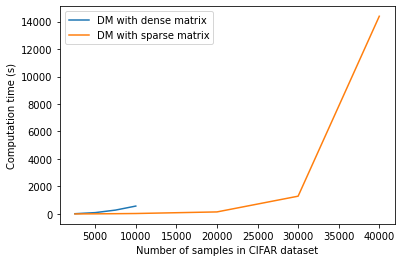

In [22]:
#20 000 samples: 269.86178183555603s
#30 000 samples: 1818.5S
    
list_samples = [2500,5000,7500,10000, 20000, 30000, 40000]

#computation_time_gray = [16.40, 102.64, 308.33, 591.66]
computation_time_dense = [18.15, 97.7900, 281.66, 574.35]
computation_time_sparse = [3.38, 9.35, 19.59, 33.23, 148.36, 1293.5, 14385.66]

plt.plot(list_samples[0:4], computation_time_dense, label='DM with dense matrix')
plt.plot(list_samples, computation_time_sparse, label='DM with sparse matrix')
plt.xlabel('Number of samples in CIFAR dataset')
plt.ylabel('Computation time (s)')
plt.legend()
plt.show()